In [1]:
import sys
sys.path.append('..')

In [2]:
from typing import Optional, List
from pathlib import Path
from collections import defaultdict
from datetime import datetime
from itertools import product

import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from tqdm.notebook import tqdm, trange

from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split, cross_val_score, KFold, StratifiedKFold
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

from myutils.stats import corrcoef, acfunc
from myutils.matplotlib import matplotlib_seaborn_style

from src.missing_values import impute_average
from src.pca import ImputePCA
from src.rzd import PlacePriceModel

matplotlib_seaborn_style()

In [3]:
results_dir = Path('../data/prediction')
results_dir.mkdir(exist_ok=True)

figures_dir = results_dir / 'figures'
figures_dir.mkdir(exist_ok=True)

In [4]:
data = pd.read_csv('../data/data.csv', parse_dates=['date'], encoding='utf-8')

data['weekday'] = data['date'].dt.weekday
data['day_name'] = data['date'].dt.day_name()

weekdays = data[['weekday', 'day_name']].drop_duplicates().sort_values(by='weekday')\
    .set_index('weekday')['day_name'].to_dict()

data.head(2)

,date,days,places,price,num,class,train,departure_hour,arrival_hour,places_frac,weekend,short_term,weekday,day_name
0,2021-04-12,1,28.0,3790.0,001А,Купе,001А-Купе,23.916667,7.916667,0.200000,0,1,0,Monday
1,2021-04-13,1,52.0,3790.0,001А,Купе,001А-Купе,23.916667,7.916667,0.371429,0,1,1,Tuesday


In [5]:
train_clusters = pd.read_csv('../data/weekends/weekly_avg_pc_clusters.csv', index_col=0)['cluster'].sort_index()

train_clusters.head()

train
001А-Купе    1
002А-Купе    2
005А-СВ      1
006А-СВ      2
701Н-СВ      0
Name: cluster, dtype: int64

In [6]:
dates = data['date'].unique()
dates.sort()

dates[:6]

array(['2021-04-12T00:00:00.000000000', '2021-04-13T00:00:00.000000000',
       '2021-04-14T00:00:00.000000000', '2021-04-15T00:00:00.000000000',
       '2021-04-16T00:00:00.000000000', '2021-04-17T00:00:00.000000000'],
      dtype='datetime64[ns]')

In [7]:
places = data.pivot(index=['train', 'date'], columns='days', values='places_frac').sort_index()

places.head()

days                        1         2         3         4         5   \
train     date                                                           
001А-Купе 2021-04-12  0.200000  0.228571  0.235714  0.514286  0.607143   
          2021-04-13  0.371429  0.392857  0.400000  0.400000  0.592857   
          2021-04-14  0.650000  0.735714  0.757143  0.764286  0.771429   
          2021-04-15  0.521429  0.664286  0.742857  0.750000  0.764286   
          2021-04-16  0.342857  0.457143  0.521429  0.585714  0.650000   

days                        6         7         8         9         10  ...  \
train     date                                                          ...   
001А-Купе 2021-04-12  0.707143  0.735714  0.750000  0.778571  0.850000  ...   
          2021-04-13  0.650000  0.735714  0.750000  0.757143  0.757143  ...   
          2021-04-14  0.821429  0.850000  0.900000       NaN  0.907143  ...   
          2021-04-15  0.764286  0.792857  0.807143  0.814286  0.835714  ...   
          2021-04-16  0.685714  0.685714  0.742857  0.807143  0.857143  ...   

days                  80  81  82  83  84  85  86  87  88  89  
train     date                                                
001А-Купе 2021-04-12 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  
          2021-04-13 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  
          2021-04-14 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  
          2021-04-15 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  
          2021-04-16 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  

[5 rows x 89 columns]

In [8]:
class Regressor:
    def __init__(self, base_regressor=DecisionTreeRegressor):
        self.base_regressor = base_regressor
        
        self.n_features = None
        self.n_targets = None
        
        self.regressors = None
        
    def fit(self, x: np.ndarray, y: np.ndarray, strata: Optional[np.ndarray] = None) -> 'Regressor':
        if strata is None:
            strata = np.zeros(x.shape[0])
        
        self.n_features = x.shape[1]
        self.n_targets = y.shape[1]
        
        x = impute_average(x)
        
        unique_strata = np.unique(strata)
        keys = list(product(unique_strata, range(self.n_targets)))
        self.regressors = dict.fromkeys(keys)
        
        for stratum, i in keys:
            x_ = x[strata == stratum]
            y_ = y[strata == stratum, i]
            
            x_ = x_[~np.isnan(y_)]
            y_ = y_[~np.isnan(y_)]
            
            regressor = self.base_regressor()
            regressor.fit(x_, y_)
            self.regressors[(stratum, i)] = regressor
            
        return self
    
    def predict(self, x: np.ndarray, strata: Optional[np.ndarray] = None) -> np.ndarray:
        if strata is None:
            strata = np.zeros(x.shape[0])
        
        x = impute_average(x)
        
        y_pred = np.empty((x.shape[0], self.n_targets))
        
        for stratum, i in product(np.unique(strata), range(self.n_targets)):
            y_pred_ = self.regressors[(stratum, i)].predict(x[strata == stratum])
            
            y_pred[strata == stratum, i] = y_pred_
            
        return y_pred

In [9]:
class PrincipalComponentRegressor:
    def __init__(self, n_components: int = 1, base_regressor=DecisionTreeRegressor):
        self.n_components = n_components
        self.base_regressor = base_regressor

        self.n_pca_features = None
        self.pcas = None
        
        self.n_regressor_features = None
        self.regressors = None
        
    def fit_predict_pca(self, x: np.ndarray, strata: Optional[np.ndarray] = None) -> np.ndarray:
        if strata is None:
            strata = np.zeros(x.shape[0])
        
        x = impute_average(x)
        
        self.n_pca_features = x.shape[1]
        
        unique_strata = np.unique(strata)
        self.pcas = dict.fromkeys(unique_strata)
        
        components = np.empty((x.shape[0], self.n_components))
        
        for stratum in unique_strata:
            pca = ImputePCA(n_components=self.n_components)
            x_ = x[strata == stratum]
            
            stratum_components = pca.fit_predict(x_)
            components[strata == stratum] = stratum_components
            
            self.pcas[stratum] = pca
            
        return components
    
    def reconstruct_pca(self, components: np.ndarray, strata: Optional[np.ndarray] = None):
        if strata is None:
            strata = np.zeros(components.shape[0])
        
        x = np.empty((components.shape[0], self.n_pca_features))
        
        for stratum in np.unique(strata):
            stratum_components = components[strata == stratum]
            x_ = self.pcas[stratum].reconstruct(stratum_components)
            
            x[strata == stratum] = x_
            
        return x
    
    def fit_regressor(self, x: np.ndarray, y: np.ndarray, strata: Optional[np.ndarray] = None):
        if strata is None:
            strata = np.zeros(x.shape[0])
        
        x = impute_average(x)
        
        assert y.shape[1] == self.n_components
        
        self.n_regressor_features = x.shape[1]
        
        unique_strata = np.unique(strata)
        keys = list(product(unique_strata, range(y.shape[1])))
        
        self.regressors = dict.fromkeys(keys)
        
        for stratum, i in keys:
            x_ = x[strata == stratum]
            y_ = y[strata == stratum, i]

            regressor = self.base_regressor()
            regressor.fit(x_, y_)
            
            self.regressors[(stratum, i)] = regressor

    def predict_regressor(self, x: np.ndarray, strata: Optional[np.ndarray] = None) -> np.ndarray:
        if strata is None:
            strata = np.zeros(x.shape[0])
        
        x = impute_average(x)
        
        y_pred = np.empty((x.shape[0], self.n_components))
        
        for stratum, i in product(np.unique(strata), range(self.n_components)):
            x_ = x[strata == stratum]
            y_pred_ = self.regressors[(stratum, i)].predict(x_)
            
            y_pred[strata == stratum, i] = y_pred_
            
        return y_pred
    
    def fit(
            self,
            x_pca: np.ndarray,
            x_regressor: np.ndarray,
            strata_pca: Optional[np.ndarray] = None,
            strata_regressor: Optional[np.ndarray] = None,
    ) -> 'PrincipalComponentRegressor':
        components = self.fit_predict_pca(x_pca, strata_pca)
        self.fit_regressor(x_regressor, components, strata_regressor)
        
        return self
    
    def predict(
            self,
            x: np.ndarray,
            strata_pca: Optional[np.ndarray] = None,
            strata_regressor: Optional[np.ndarray] = None,
    ) -> np.ndarray:
        components_pred = self.predict_regressor(x, strata_regressor)
        x_pred = self.reconstruct_pca(components_pred, strata_pca)
        
        return x_pred

In [10]:
x = places.values

cols = np.arange(45)
fit_cols = cols[-15:]
predict_cols = cols[:-15]

x_pca = x[:, cols]
x_regressor = x[:, fit_cols]
y = x[:, predict_cols]

mask = ((~np.isnan(x_pca)).sum(axis=1) >= 2) & ((~np.isnan(x_regressor)).sum(axis=1) >= 2)

x = x[mask]
x_pca = x_pca[mask]
x_regressor = x_regressor[mask]
y = y[mask]

train_strata = places.index.get_level_values(0).values[mask]
cluster_strata = places.index.get_level_values(0).map(train_clusters).values[mask]

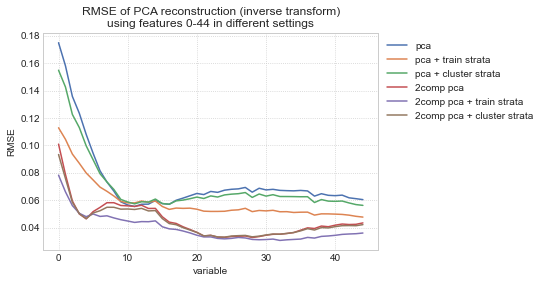

In [11]:
pcregr = PrincipalComponentRegressor()
pcs = pcregr.fit_predict_pca(x_pca)
x_pca_pred = pcregr.reconstruct_pca(pcs)

scores = np.nanmean((x_pca - x_pca_pred) ** 2, axis=0) ** 0.5
plt.plot(scores, label='pca')

pcregr = PrincipalComponentRegressor()
pcs = pcregr.fit_predict_pca(x_pca, train_strata)
x_pca_pred = pcregr.reconstruct_pca(pcs, train_strata)

scores = np.nanmean((x_pca - x_pca_pred) ** 2, axis=0) ** 0.5
plt.plot(scores, label='pca + train strata')

pcregr = PrincipalComponentRegressor()
pcs = pcregr.fit_predict_pca(x_pca, cluster_strata)
x_pca_pred = pcregr.reconstruct_pca(pcs, cluster_strata)

scores = np.nanmean((x_pca - x_pca_pred) ** 2, axis=0) ** 0.5
plt.plot(scores, label='pca + cluster strata')

pcregr = PrincipalComponentRegressor(2)
pcs = pcregr.fit_predict_pca(x_pca)
x_pca_pred = pcregr.reconstruct_pca(pcs)

scores = np.nanmean((x_pca - x_pca_pred) ** 2, axis=0) ** 0.5
plt.plot(scores, label='2comp pca')

pcregr = PrincipalComponentRegressor(2)
pcs = pcregr.fit_predict_pca(x_pca, train_strata)
x_pca_pred = pcregr.reconstruct_pca(pcs, train_strata)

scores = np.nanmean((x_pca - x_pca_pred) ** 2, axis=0) ** 0.5
plt.plot(scores, label='2comp pca + train strata')

pcregr = PrincipalComponentRegressor(2)
pcs = pcregr.fit_predict_pca(x_pca, cluster_strata)
x_pca_pred = pcregr.reconstruct_pca(pcs, cluster_strata)

scores = np.nanmean((x_pca - x_pca_pred) ** 2, axis=0) ** 0.5
plt.plot(scores, label='2comp pca + cluster strata')

plt.title(f'RMSE of PCA reconstruction (inverse transform)\n'
          f'using features {cols[0]}-{cols[-1]} in different settings')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.xlabel('variable')
plt.ylabel('RMSE')

plt.savefig(figures_dir / f'pca_reconstruction_{cols[0]}_{cols[-1]}.pdf',
            transparent=True, bbox_inches='tight')

  0%|          | 0/5 [00:00<?, ?it/s]

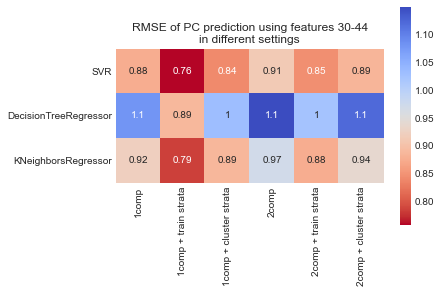

In [12]:
pcregr = PrincipalComponentRegressor()
pcs = pcregr.fit_predict_pca(x_pca, train_strata)

pcregr = PrincipalComponentRegressor(2)
pcs_2comp = pcregr.fit_predict_pca(x_pca, train_strata)

base_regressors = [SVR, DecisionTreeRegressor, KNeighborsRegressor]
index = [regressor.__name__ for regressor in base_regressors]
setups = ['1comp', '1comp + train strata', '1comp + cluster strata',
          '2comp', '2comp + train strata', '2comp + cluster strata']

scores = pd.DataFrame(index=index, columns=setups, dtype=float)
cv_scores = []

kfold = StratifiedKFold(5, shuffle=True)

for train_idx, test_idx in tqdm(kfold.split(x, train_strata), total=kfold.get_n_splits()):
    x_pca_train = x_pca[train_idx]
    x_pca_test = x_pca[test_idx]
    
    x_regressor_train = x_regressor[train_idx]
    x_regressor_test = x_regressor[test_idx]
    
    y_train = y[train_idx]
    y_test = y[test_idx]
    
    train_strata_train = train_strata[train_idx]
    train_strata_test = train_strata[test_idx]
    
    cluster_strata_train = cluster_strata[train_idx]
    cluster_strata_test = cluster_strata[test_idx]
    
    pcs_train = pcs[train_idx]
    pcs_test = pcs[test_idx]

    pcs_2comp_train = pcs_2comp[train_idx]
    pcs_2comp_test = pcs_2comp[test_idx]
    
    scores_ = scores.copy()
    
    for i, base_regressor in enumerate(base_regressors):
        pcregr = PrincipalComponentRegressor(base_regressor=base_regressor)
        pcregr.fit_regressor(x_regressor_train, pcs_train)
        pcs_pred = pcregr.predict_regressor(x_regressor_test)
        scores_.iloc[i, 0] = mean_squared_error(pcs_test, pcs_pred) ** 0.5

        pcregr = PrincipalComponentRegressor(base_regressor=base_regressor)
        pcregr.fit_regressor(x_regressor_train, pcs_train, train_strata_train)
        pcs_pred = pcregr.predict_regressor(x_regressor_test, train_strata_test)
        scores_.iloc[i, 1] = mean_squared_error(pcs_test, pcs_pred) ** 0.5

        pcregr = PrincipalComponentRegressor(base_regressor=base_regressor)
        pcregr.fit_regressor(x_regressor_train, pcs_train, cluster_strata_train)
        pcs_pred = pcregr.predict_regressor(x_regressor_test, cluster_strata_test)
        scores_.iloc[i, 2] = mean_squared_error(pcs_test, pcs_pred) ** 0.5

        pcregr = PrincipalComponentRegressor(2, base_regressor=base_regressor)
        pcregr.fit_regressor(x_regressor_train, pcs_2comp_train)
        pcs_pred = pcregr.predict_regressor(x_regressor_test)
        scores_.iloc[i, 3] = mean_squared_error(pcs_2comp_test, pcs_pred) ** 0.5

        pcregr = PrincipalComponentRegressor(2, base_regressor=base_regressor)
        pcregr.fit_regressor(x_regressor_train, pcs_2comp_train, train_strata_train)
        pcs_pred = pcregr.predict_regressor(x_regressor_test, train_strata_test)
        scores_.iloc[i, 4] = mean_squared_error(pcs_2comp_test, pcs_pred) ** 0.5

        pcregr = PrincipalComponentRegressor(2, base_regressor=base_regressor)
        pcregr.fit_regressor(x_regressor_train, pcs_2comp_train, cluster_strata_train)
        pcs_pred = pcregr.predict_regressor(x_regressor_test, cluster_strata_test)
        scores_.iloc[i, 5] = mean_squared_error(pcs_2comp_test, pcs_pred) ** 0.5
    
    cv_scores.append(scores_)
    
scores = sum(cv_scores) / len(cv_scores)

sns.heatmap(scores, square=True, annot=True, cmap='coolwarm_r')
plt.title(f'RMSE of PC prediction using features {fit_cols[0]}-{fit_cols[-1]}\nin different settings')

plt.savefig(figures_dir / f'pca_prediction_{fit_cols[0]}_{fit_cols[-1]}.pdf',
            transparent=True, bbox_inches='tight')

  0%|          | 0/5 [00:00<?, ?it/s]

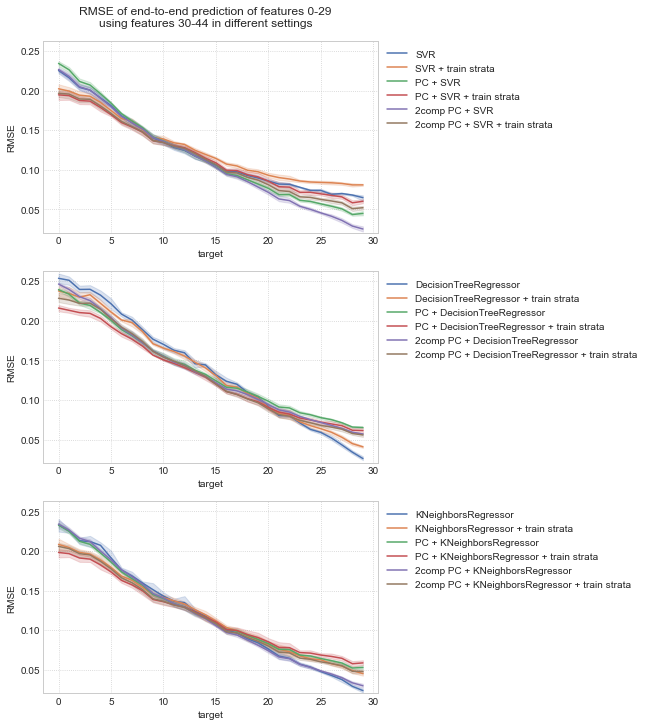

In [13]:
base_regressors = [SVR, DecisionTreeRegressor, KNeighborsRegressor]

results = []

kfold = StratifiedKFold(5, shuffle=True)

for train_idx, test_idx in tqdm(kfold.split(x, train_strata), total=kfold.get_n_splits()):
    x_pca_train = x_pca[train_idx]
    x_pca_test = x_pca[test_idx]
    
    x_regressor_train = x_regressor[train_idx]
    x_regressor_test = x_regressor[test_idx]
    
    y_train = y[train_idx]
    y_test = y[test_idx]
    
    train_strata_train = train_strata[train_idx]
    train_strata_test = train_strata[test_idx]
    
    cluster_strata_train = cluster_strata[train_idx]
    cluster_strata_test = cluster_strata[test_idx]
    
    for base_regressor in base_regressors:
        regressor = Regressor(base_regressor=base_regressor).fit(x_regressor_train, y_train)
        y_pred = regressor.predict(x_regressor_test)
        scores = np.nanmean((y_test - y_pred) ** 2, axis=0) ** 0.5

        for col, score in zip(predict_cols, scores):
            results.append({
                'model': base_regressor.__name__,
                'target': col,
                'score': score,
            })
            
        regressor = Regressor(base_regressor=base_regressor).fit(x_regressor_train, y_train, train_strata_train)
        y_pred = regressor.predict(x_regressor_test, train_strata_test)
        scores = np.nanmean((y_test - y_pred) ** 2, axis=0) ** 0.5

        for col, score in zip(predict_cols, scores):
            results.append({
                'model': base_regressor.__name__ + ' + train strata',
                'target': col,
                'score': score,
            })
            
        pcregr = PrincipalComponentRegressor(base_regressor=base_regressor)
        pcregr.fit(x_pca_train, x_regressor_train)
        y_pred = pcregr.predict(x_regressor_test)[:, predict_cols]
        scores = np.nanmean((y_test - y_pred) ** 2, axis=0) ** 0.5

        for col, score in zip(predict_cols, scores):
            results.append({
                'model': 'PC + ' + base_regressor.__name__,
                'target': col,
                'score': score,
            })
                        
        pcregr = PrincipalComponentRegressor(base_regressor=base_regressor)
        pcregr.fit(x_pca_train, x_regressor_train,
                   strata_pca=train_strata_train, strata_regressor=train_strata_train)
        y_pred = pcregr.predict(x_regressor_test, strata_pca=train_strata_test,
                                strata_regressor=train_strata_test)[:, predict_cols]
        scores = np.nanmean((y_test - y_pred) ** 2, axis=0) ** 0.5

        for col, score in zip(predict_cols, scores):
            results.append({
                'model': 'PC + ' + base_regressor.__name__ + ' + train strata',
                'target': col,
                'score': score,
            })
            
        pcregr = PrincipalComponentRegressor(2, base_regressor=base_regressor)
        pcregr.fit(x_pca_train, x_regressor_train)
        y_pred = pcregr.predict(x_regressor_test)[:, predict_cols]
        scores = np.nanmean((y_test - y_pred) ** 2, axis=0) ** 0.5

        for col, score in zip(predict_cols, scores):
            results.append({
                'model': '2comp PC + ' + base_regressor.__name__,
                'target': col,
                'score': score,
            })
                        
        pcregr = PrincipalComponentRegressor(2, base_regressor=base_regressor)
        pcregr.fit(x_pca_train, x_regressor_train,
                   strata_pca=train_strata_train, strata_regressor=train_strata_train)
        y_pred = pcregr.predict(x_regressor_test, strata_pca=train_strata_test,
                                strata_regressor=train_strata_test)[:, predict_cols]
        scores = np.nanmean((y_test - y_pred) ** 2, axis=0) ** 0.5

        for col, score in zip(predict_cols, scores):
            results.append({
                'model': '2comp PC + ' + base_regressor.__name__ + ' + train strata',
                'target': col,
                'score': score,
            })

results = pd.DataFrame(results)

fig, axes = plt.subplots(nrows=len(base_regressors))
fig.set_size_inches(6, 4 * len(base_regressors))

vmin = results['score'].min()
vmax = results['score'].max()

for ax, base_regressor in zip(axes, base_regressors):
    mask = results['model'].str.contains(base_regressor.__name__)
    
    sns.lineplot(ax=ax, data=results[mask], x='target', y='score', hue='model')
    ax.set_ylim(vmin, vmax)

    ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
    ax.set_ylabel('RMSE')

plt.suptitle(f'RMSE of end-to-end prediction of features {predict_cols[0]}-{predict_cols[-1]}\n'
             f'using features {fit_cols[0]}-{fit_cols[-1]} in different settings', y=0.92)

plt.savefig(figures_dir / f'prediction_{predict_cols[0]}_{predict_cols[-1]}_{fit_cols[0]}_{fit_cols[-1]}.pdf',
            transparent=True, bbox_inches='tight')

In [15]:
!jupyter nbconvert --to html prediction.ipynb

[NbConvertApp] Converting notebook prediction.ipynb to html
[NbConvertApp] Writing 933783 bytes to prediction.html
